**Aim**

The aim of this project is to develop and compare machine learning algorithms from a large patient data set provided by LTHT. Comparison of the best model obtained will be compared with consultant grade interpretations to determine the effectiveness. If successful, this project would demonstrate how the incorporation of machine learning and AI into the clinical field can harmonise reporting while reducing human input; a finding yet to be fully documented.

**Objectives**

•	Read and analyse background literature related to interpretation of blood test results and about decision support systems for clinical diagnosis, and hypo/hypercalcaemia in particular

•	Split dataset into training, validation and test sets

•	Pre-process the data for training

•	Train a few machine learning models to interpret blood test results

•	Evaluate results

•	Implement a machine learning ensemble

•	Visualise the decision tree(s)

•	Finish code and write final project report


In [1]:
import os
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import seaborn as sn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from sklearn import tree
from sklearn.model_selection import GridSearchCV, ParameterGrid
#root_dir = '/Specify/Path/' # this is to be defined by you 
#local_path = '/datasets/COMP5611M_Assessment/' # store the related data files in this folder

data_dir = '/content/drive/MyDrive/MSc Project/data/'
## Define paths to the training data and targets files
training_data_path = data_dir + 'dataset.xlsx'

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Load and Summarise Dataset**

In [4]:
df = pd.read_excel(training_data_path, index_col=0)
dataset = df.copy()

In [ ]:
dataset.head(10)

PTH    Ca  Vit D   Mg  eGFR Interpretation
Patient                                             
1.0       1.1  1.90   72.0  0.1  80.0             A1
2.0      15.4  2.85   90.0  0.9  66.0              I
3.0       0.7  1.70   89.0  1.0  90.0             A2
4.0       2.3  1.90   60.0  0.1  80.0             B1
5.0      12.2  1.70   32.0  1.0  90.0             C1
6.0       0.5  2.92   95.0  1.3  71.0              G
7.0       0.5  2.10   63.0  0.2  88.0             A1
8.0       6.4  1.70   89.0  1.3  90.0             B2
9.0       0.5  2.90   75.0  1.4  71.0              G
10.0      1.4  1.80   94.0  0.2  90.0             A1

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 400 entries, 1.0 to 400.0
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PTH             400 non-null    float64
 1   Ca              400 non-null    float64
 2   Vit D           390 non-null    float64
 3   Mg              380 non-null    float64
 4   eGFR            400 non-null    float64
 5   Interpretation  400 non-null    object 
dtypes: float64(5), object(1)
memory usage: 21.9+ KB


In [ ]:
print(dataset.groupby('Interpretation').size())

Interpretation
A1    25
A2    29
A3     8
B1    23
B2    26
B3    12
C1    28
C2    20
C3    10
D     30
E     28
F1    26
F2    24
F3    25
G     30
H     30
I     26
dtype: int64


In [ ]:
dataset.describe()

PTH          Ca       Vit D          Mg        eGFR
count  400.000000  400.000000  390.000000  380.000000  400.000000
mean     5.918325    2.324825   69.312821    1.059737   84.670000
std      4.929397    0.353903   21.008985    0.903517    6.507455
min      0.300000    1.650000   17.000000    0.100000   65.000000
25%      1.100000    2.100000   58.000000    0.700000   80.000000
50%      4.750000    2.250000   75.000000    1.000000   88.000000
75%     10.050000    2.532500   84.000000    1.300000   90.000000
max     22.000000    3.200000  105.000000    9.000000   90.000000

# **Data Visualisation**

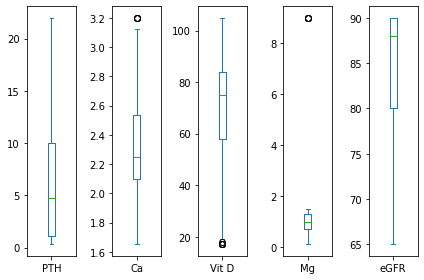

In [ ]:
# box plot
dataset.plot(kind='box', subplots=True, layout=(1,5), sharex=False, sharey=False)
plt.tight_layout()
plt.show()

In [5]:
# replace null values with -99
dataset['Vit D'] = dataset['Vit D'].fillna(-99)
dataset['Mg'] = dataset['Mg'].fillna(-99)

In [6]:
q = dataset["Mg"].quantile(0.99)
dataset = dataset[dataset["Mg"] < q]
dataset

PTH    Ca  Vit D   Mg  eGFR Interpretation
Patient                                             
1.0       1.1  1.90   72.0  0.1  80.0             A1
2.0      15.4  2.85   90.0  0.9  66.0              I
3.0       0.7  1.70   89.0  1.0  90.0             A2
4.0       2.3  1.90   60.0  0.1  80.0             B1
5.0      12.2  1.70   32.0  1.0  90.0             C1
...       ...   ...    ...  ...   ...            ...
396.0    15.4  2.85   90.0  0.9  66.0              I
397.0     0.7  1.70   89.0  1.0  90.0             A2
398.0     2.3  1.90   60.0  0.1  80.0             B1
399.0    12.2  1.70   32.0  1.0  90.0             C1
400.0     0.5  2.92   95.0  1.3  71.0              G

[396 rows x 6 columns]

In [ ]:
q = dataset["Ca"].quantile(0.97)
dataset = dataset[dataset["Ca"] < q]

In [7]:
duplicateRows = dataset[dataset.duplicated(keep='last')]
duplicateRows.count()

PTH               46
Ca                46
Vit D             46
Mg                46
eGFR              46
Interpretation    46
dtype: int64

In [8]:
dataset = dataset.drop_duplicates(keep = 'last')

In [9]:
duplicateRows = dataset[dataset.duplicated(keep='last')]
duplicateRows.count()

PTH               0
Ca                0
Vit D             0
Mg                0
eGFR              0
Interpretation    0
dtype: int64

In [10]:
print(dataset.groupby('Interpretation').size())

Interpretation
A1    19
A2    20
A3     8
B1    21
B2    21
B3    12
C1    25
C2    20
C3     9
D     26
E     23
F1    24
F2    24
F3    24
G     26
H     25
I     23
dtype: int64


In [11]:
y = dataset.Interpretation
y.describe()

count     350
unique     17
top         D
freq       26
Name: Interpretation, dtype: object

In [12]:
features = ['PTH', 'Ca', 'Vit D', 'Mg', 'eGFR']

In [13]:
X = dataset[features]

In [14]:
X.head()

PTH   Ca  Vit D   Mg  eGFR
Patient                             
7.0       0.5  2.1   63.0  0.2  88.0
8.0       6.4  1.7   89.0  1.3  90.0
9.0       0.5  2.9   75.0  1.4  71.0
10.0      1.4  1.8   94.0  0.2  90.0
11.0     12.3  2.0   43.0  1.4  71.0

In [15]:
num_pipeline = Pipeline(steps=[
       ('imputer', SimpleImputer(strategy='mean')),
       ('scaler', StandardScaler())
])

data = num_pipeline.fit_transform(X)
print(data[1])

[ 0.04971708 -1.79831447  0.72302942  0.25966517  0.82217458]


In [16]:
X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.20, random_state=1)

In [17]:
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))
#models.append(('RF',RandomForestClassifier()))

# evaluation of each model
results = []
names = []
for name, model in models:
	kfold = StratifiedKFold(n_splits=7, random_state=1, shuffle=True)
	cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LR: 0.646429 (0.064681)
LDA: 0.832143 (0.074059)
KNN: 0.289286 (0.071785)
CART: 0.932143 (0.025754)
NB: 0.892857 (0.037115)
SVM: 0.407143 (0.074059)


In [18]:
model = DecisionTreeClassifier()
model.fit(X_train, Y_train)
predictions = model.predict(X_validation)

In [19]:
print(accuracy_score(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.9142857142857143
              precision    recall  f1-score   support

          A1       0.67      1.00      0.80         2
          A2       1.00      1.00      1.00         2
          A3       0.00      0.00      0.00         1
          B1       1.00      1.00      1.00         5
          B2       1.00      1.00      1.00         3
          B3       0.75      0.75      0.75         4
          C1       1.00      1.00      1.00         9
          C2       0.71      1.00      0.83         5
          C3       1.00      1.00      1.00         1
           D       1.00      1.00      1.00         2
           E       1.00      1.00      1.00         9
          F1       0.67      0.67      0.67         3
          F2       0.75      0.50      0.60         6
          F3       1.00      1.00      1.00         6
           G       1.00      1.00      1.00         4
           H       1.00      1.00      1.00         3
           I       1.00      1.00      1.00         5

    acc

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


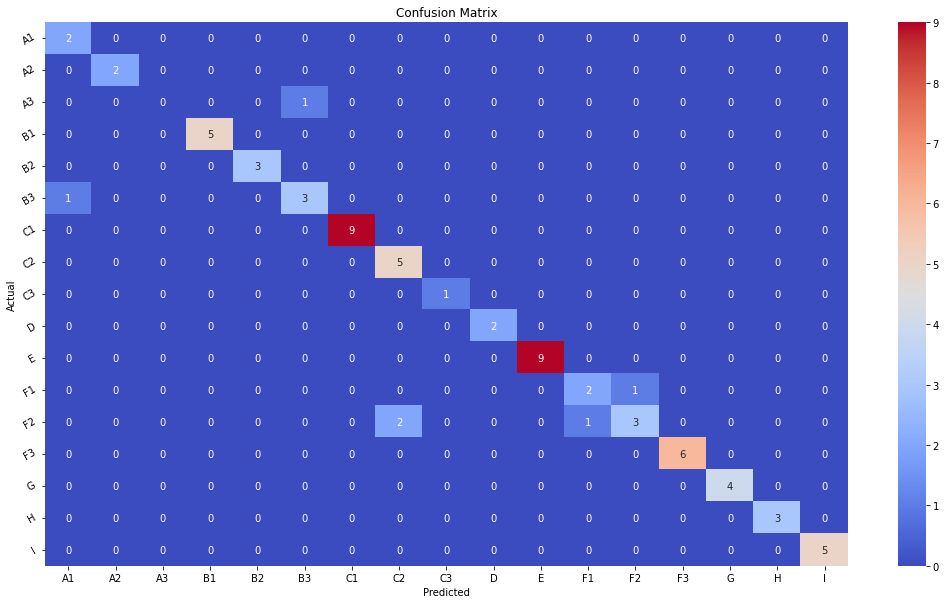

In [20]:
cf_matrix = confusion_matrix(Y_validation, predictions)
plt.figure(figsize = (18,10))
axes = sn.heatmap(cf_matrix, cmap='coolwarm', annot=True, fmt="g")
class_labels = ['A1','A2','A3','B1','B2','B3','C1','C2','C3','D','E','F1','F2','F3','G','H','I']
tick_marks = np.arange(len(class_labels)) + 0.5

axes.set_xticks(tick_marks)
axes.set_xticklabels(class_labels,rotation=0)

axes.set_yticks(tick_marks)
axes.set_yticklabels(class_labels,rotation=30)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [21]:
forest_model = RandomForestClassifier(random_state=42, n_estimators=30)
forest_model.fit(X_train, Y_train)
preds = forest_model.predict(X_validation)

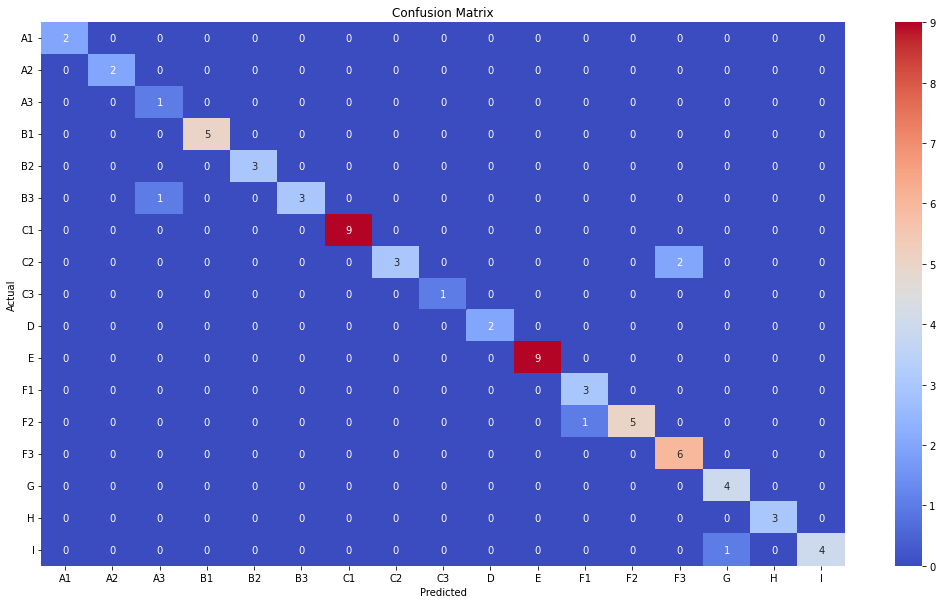

In [22]:
cf_matrix = confusion_matrix(Y_validation, preds)
plt.figure(figsize = (18,10))
axes = sn.heatmap(cf_matrix, cmap='coolwarm', annot=True, fmt="g")
class_labels = ['A1','A2','A3','B1','B2','B3','C1','C2','C3','D','E','F1','F2','F3','G','H','I']
tick_marks = np.arange(len(class_labels)) + 0.5

axes.set_xticks(tick_marks)
axes.set_xticklabels(class_labels,rotation=0)

axes.set_yticks(tick_marks)
axes.set_yticklabels(class_labels,rotation=0)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [23]:
print(accuracy_score(Y_validation, preds))

0.9285714285714286


In [24]:
print(classification_report(Y_validation, preds))

              precision    recall  f1-score   support

          A1       1.00      1.00      1.00         2
          A2       1.00      1.00      1.00         2
          A3       0.50      1.00      0.67         1
          B1       1.00      1.00      1.00         5
          B2       1.00      1.00      1.00         3
          B3       1.00      0.75      0.86         4
          C1       1.00      1.00      1.00         9
          C2       1.00      0.60      0.75         5
          C3       1.00      1.00      1.00         1
           D       1.00      1.00      1.00         2
           E       1.00      1.00      1.00         9
          F1       0.75      1.00      0.86         3
          F2       1.00      0.83      0.91         6
          F3       0.75      1.00      0.86         6
           G       0.80      1.00      0.89         4
           H       1.00      1.00      1.00         3
           I       1.00      0.80      0.89         5

    accuracy              

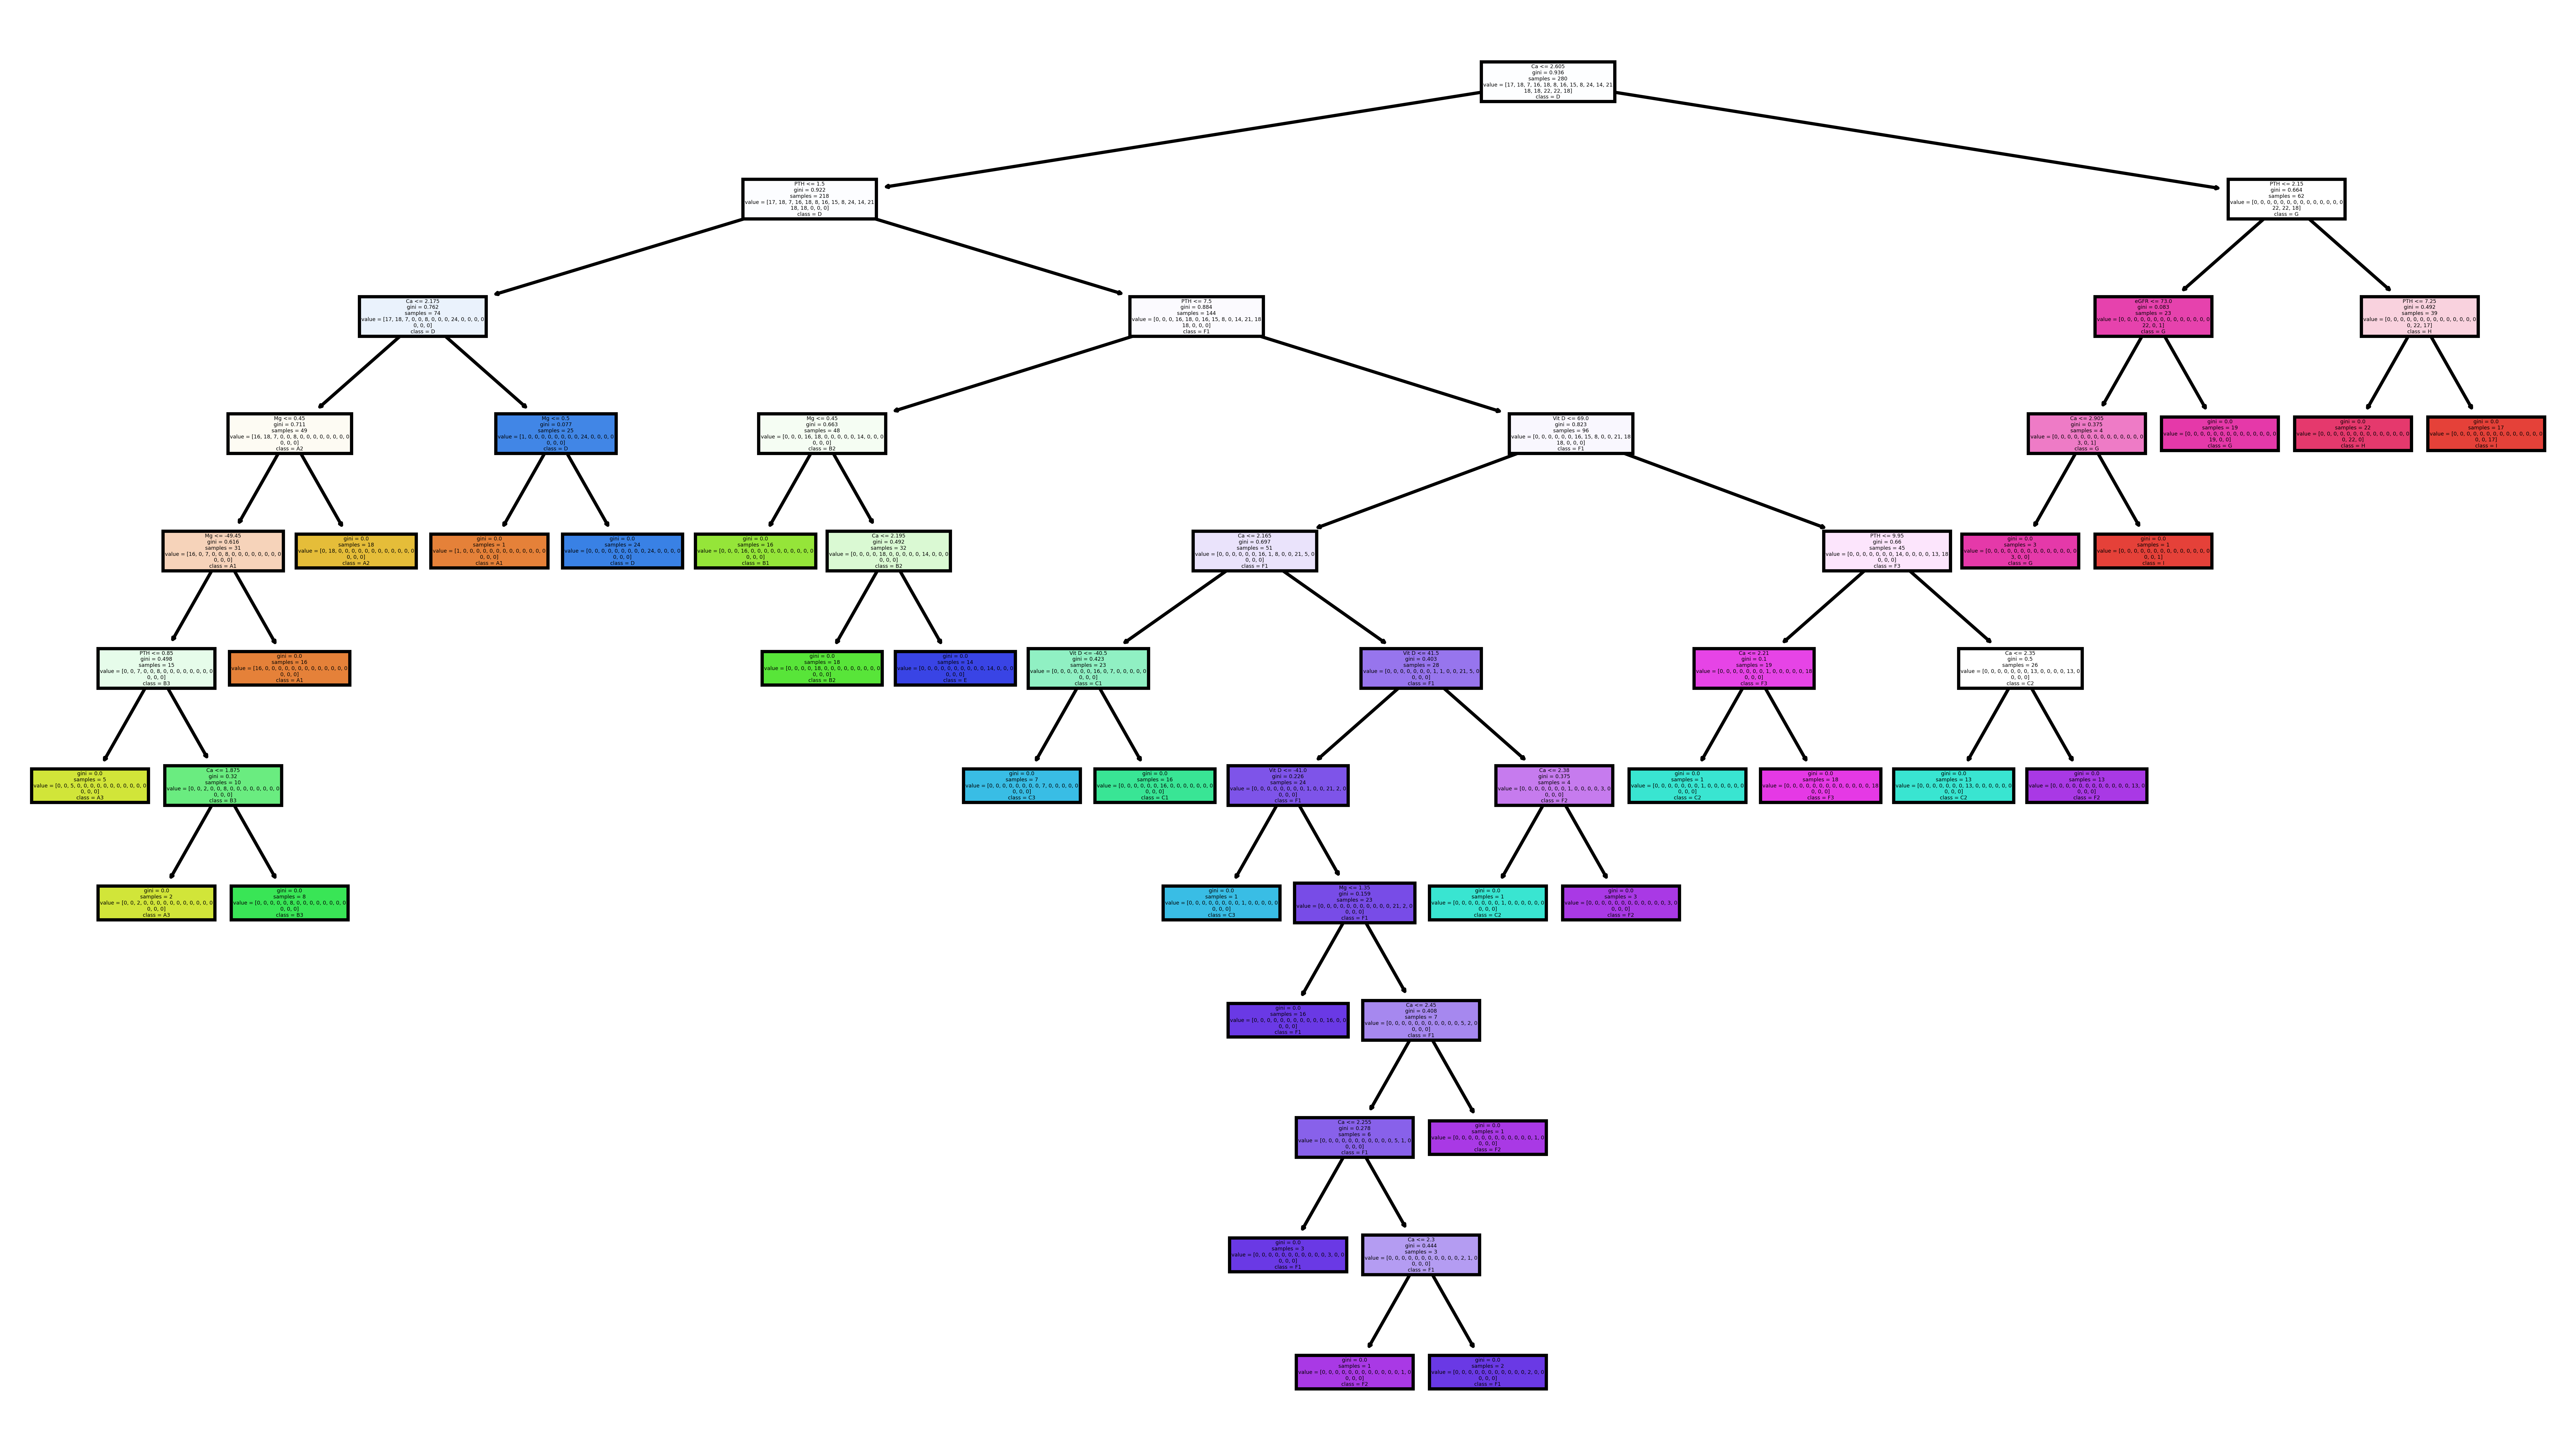

In [ ]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (14,8), dpi=800)
tree.plot_tree(model,
               feature_names = features,
               class_names=class_labels,
               filled = True);
fig.savefig('/content/drive/MyDrive/MSc Project/decision_tree.png')

In [ ]:
print(len(forest_model.estimators_))

30


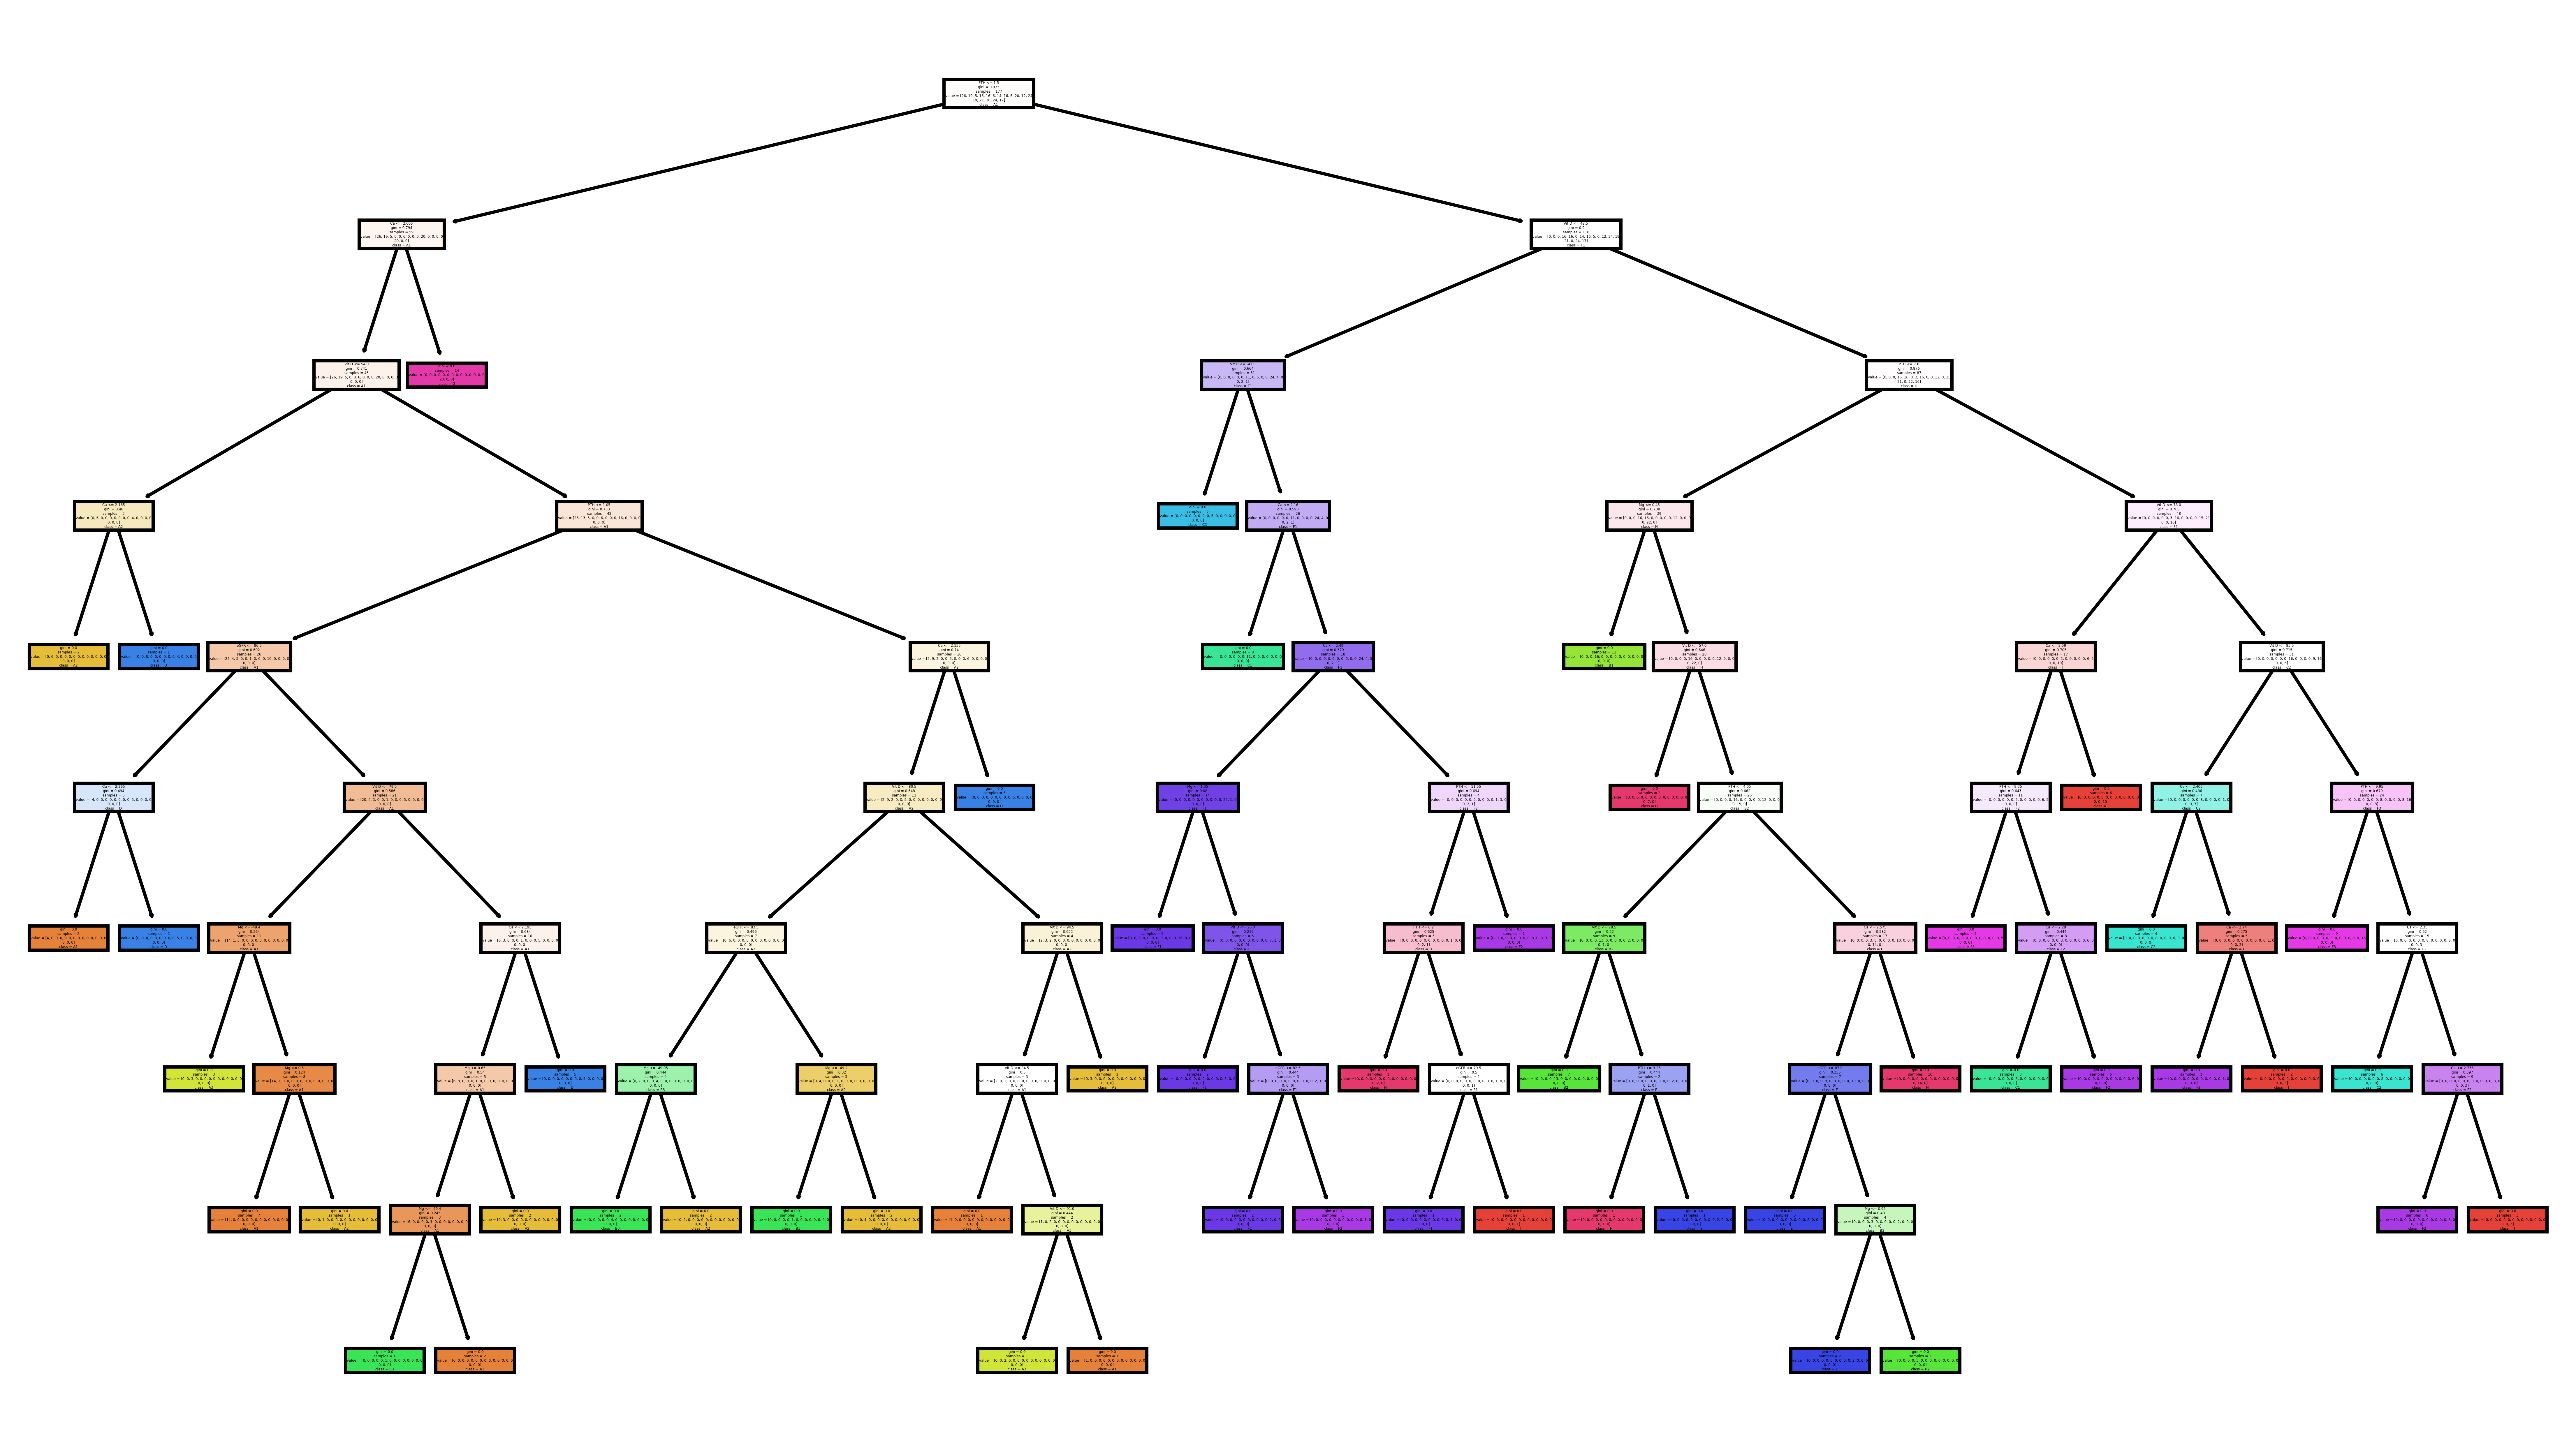

In [ ]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (14,8), dpi=800)
tree.plot_tree(forest_model.estimators_[0],
               feature_names = features,
               class_names=class_labels,
               filled = True);
fig.savefig('/content/drive/MyDrive/MSc Project/forest_tree1.png')

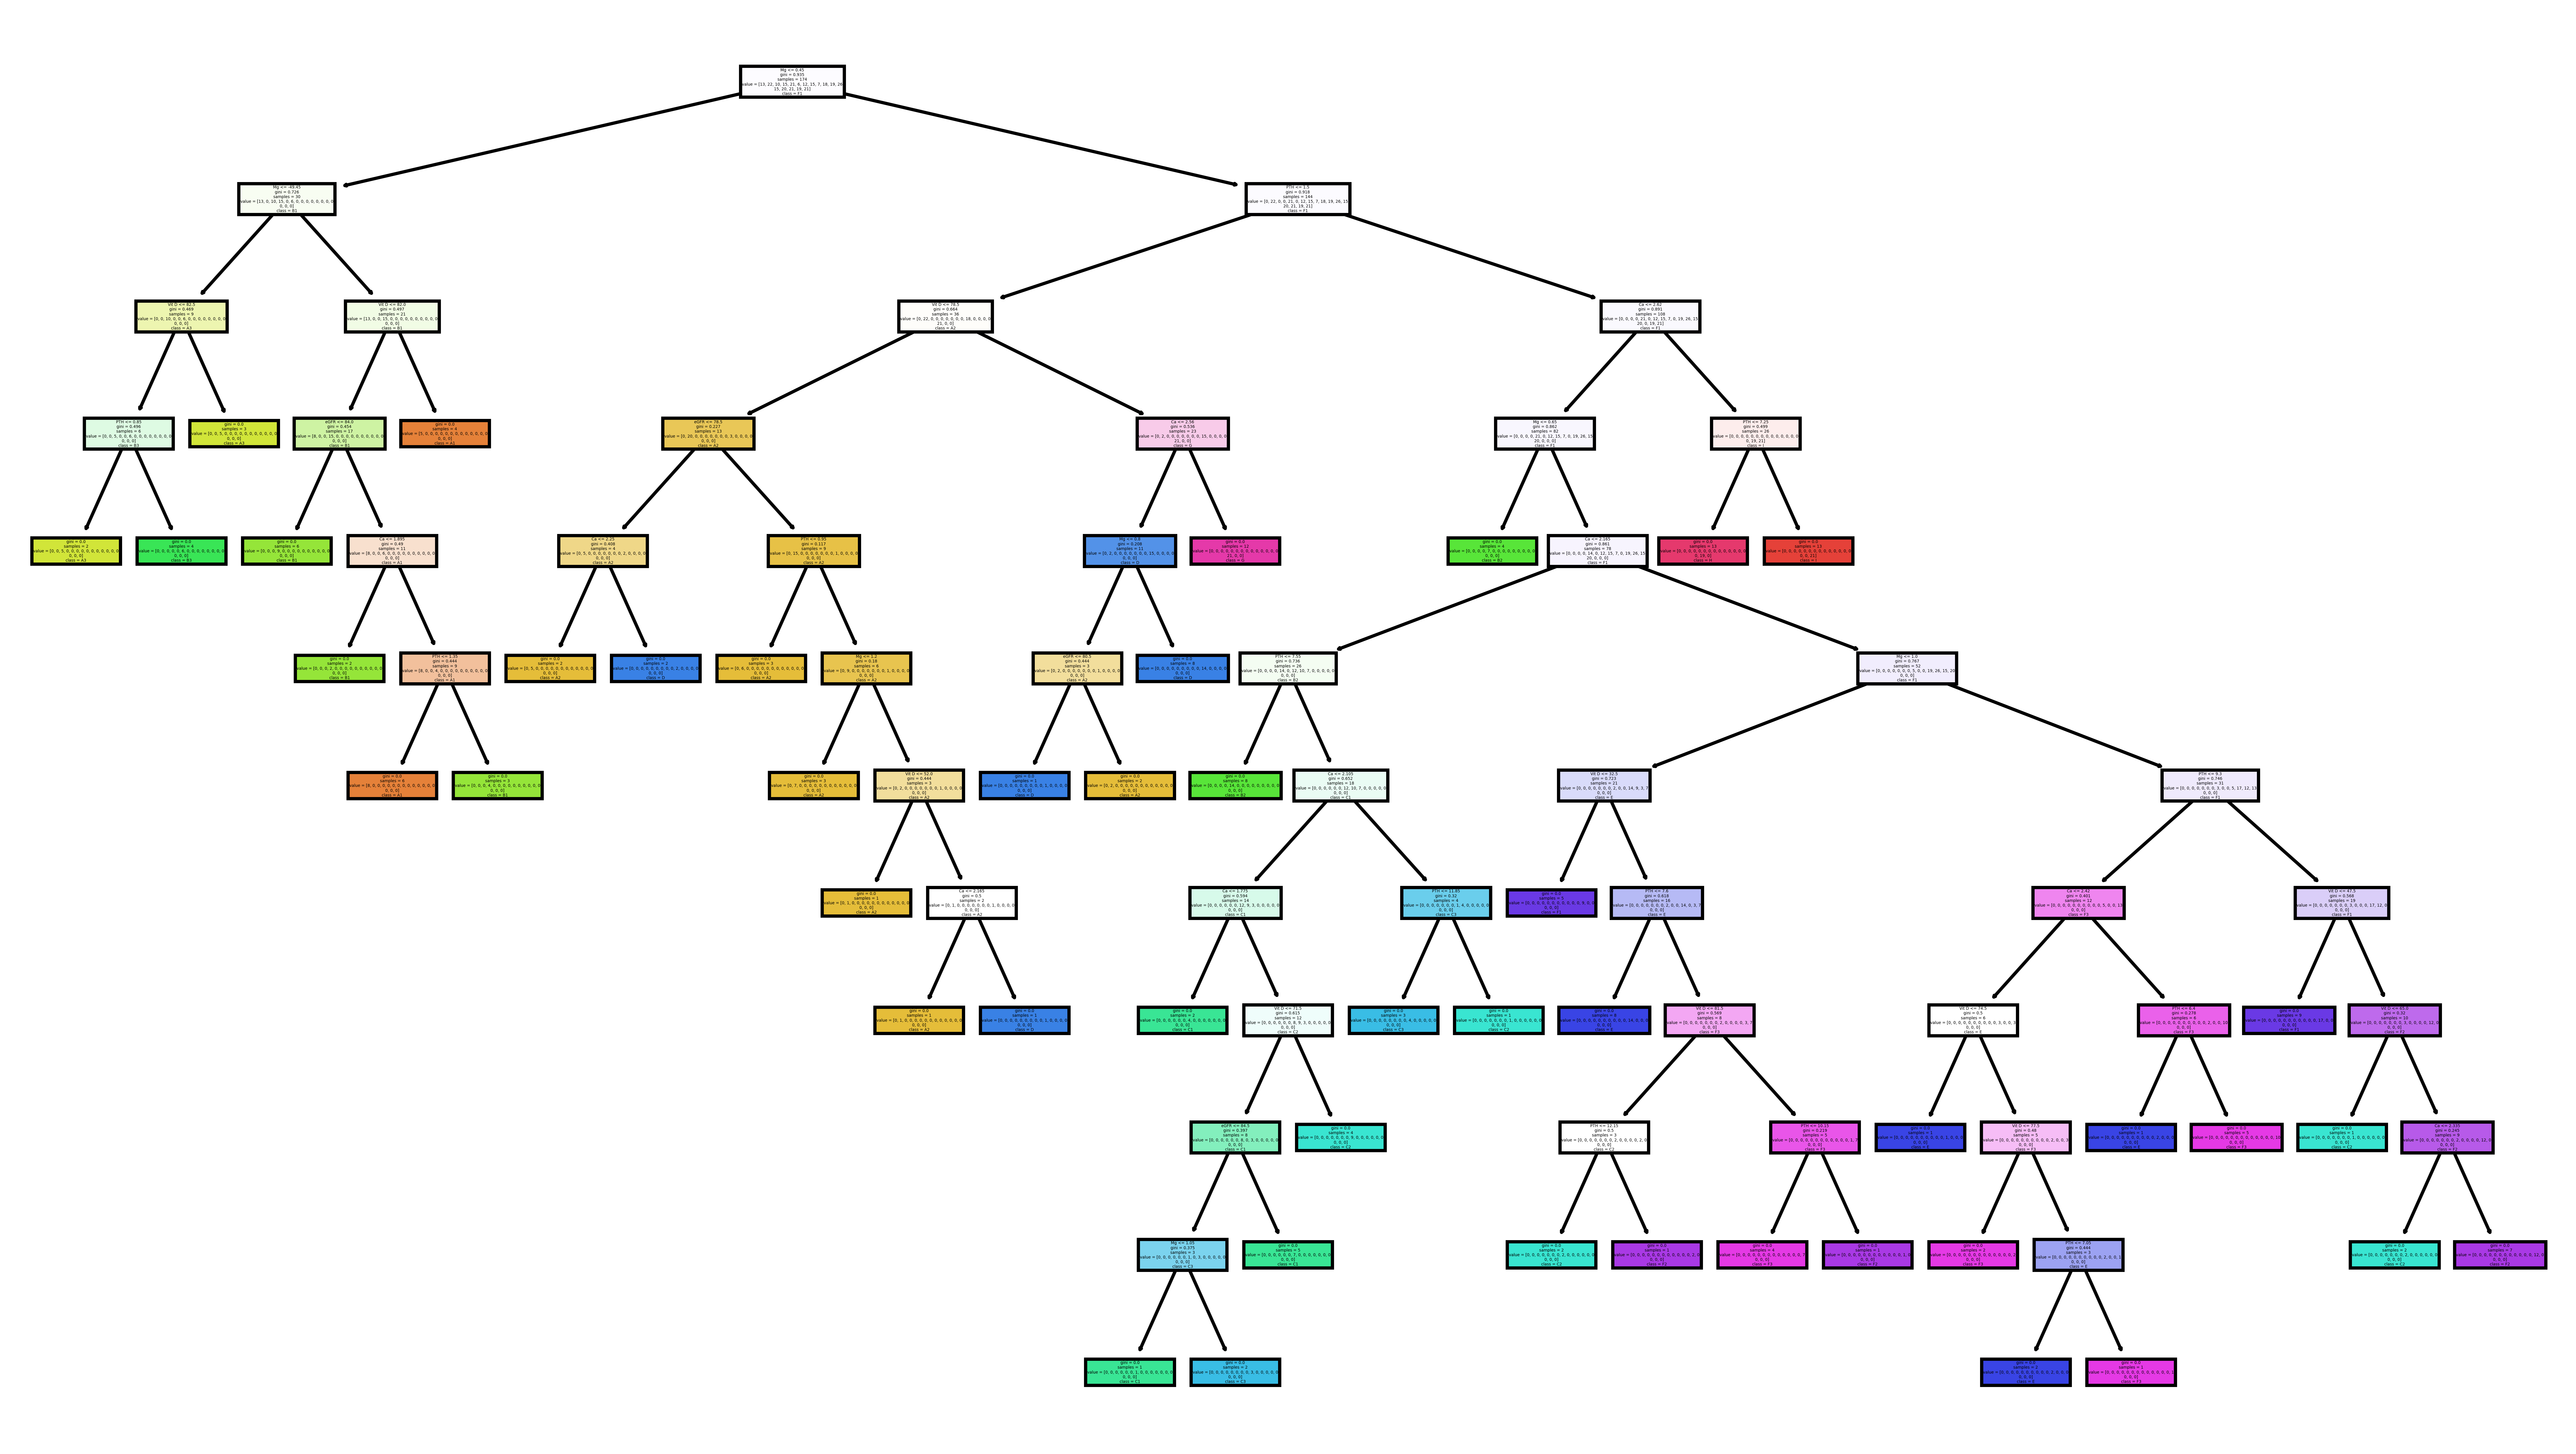

In [ ]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (14,8), dpi=800)
tree.plot_tree(forest_model.estimators_[15],
               feature_names = features,
               class_names=class_labels,
               filled = True);
fig.savefig('/content/drive/MyDrive/MSc Project/forest_tree15.png')

In [25]:
ccp_alphas = model.cost_complexity_pruning_path(X_train, Y_train)["ccp_alphas"]

In [26]:
ccp_alphas

array([0.        , 0.00297619, 0.00341615, 0.00354555, 0.00535714,
       0.00630176, 0.00676692, 0.00685714, 0.01142857, 0.0152381 ,
       0.01560374, 0.03478261, 0.0415361 , 0.04642857, 0.05126141,
       0.05625   , 0.05628703, 0.05744048, 0.05875496, 0.06594901,
       0.06849817, 0.07154208])

In [27]:
grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=1),
    scoring=make_scorer(accuracy_score),
    param_grid=ParameterGrid({"ccp_alpha": [[alpha] for alpha in ccp_alphas]}),
)

In [28]:
grid_search.fit(X_train, Y_train)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=1),
             param_grid=<sklearn.model_selection._search.ParameterGrid object at 0x7f628176c390>,
             scoring=make_scorer(accuracy_score))

In [29]:
grid_search.best_params_

{'ccp_alpha': 0.005357142857142857}

In [30]:
best_tree = grid_search.best_estimator_

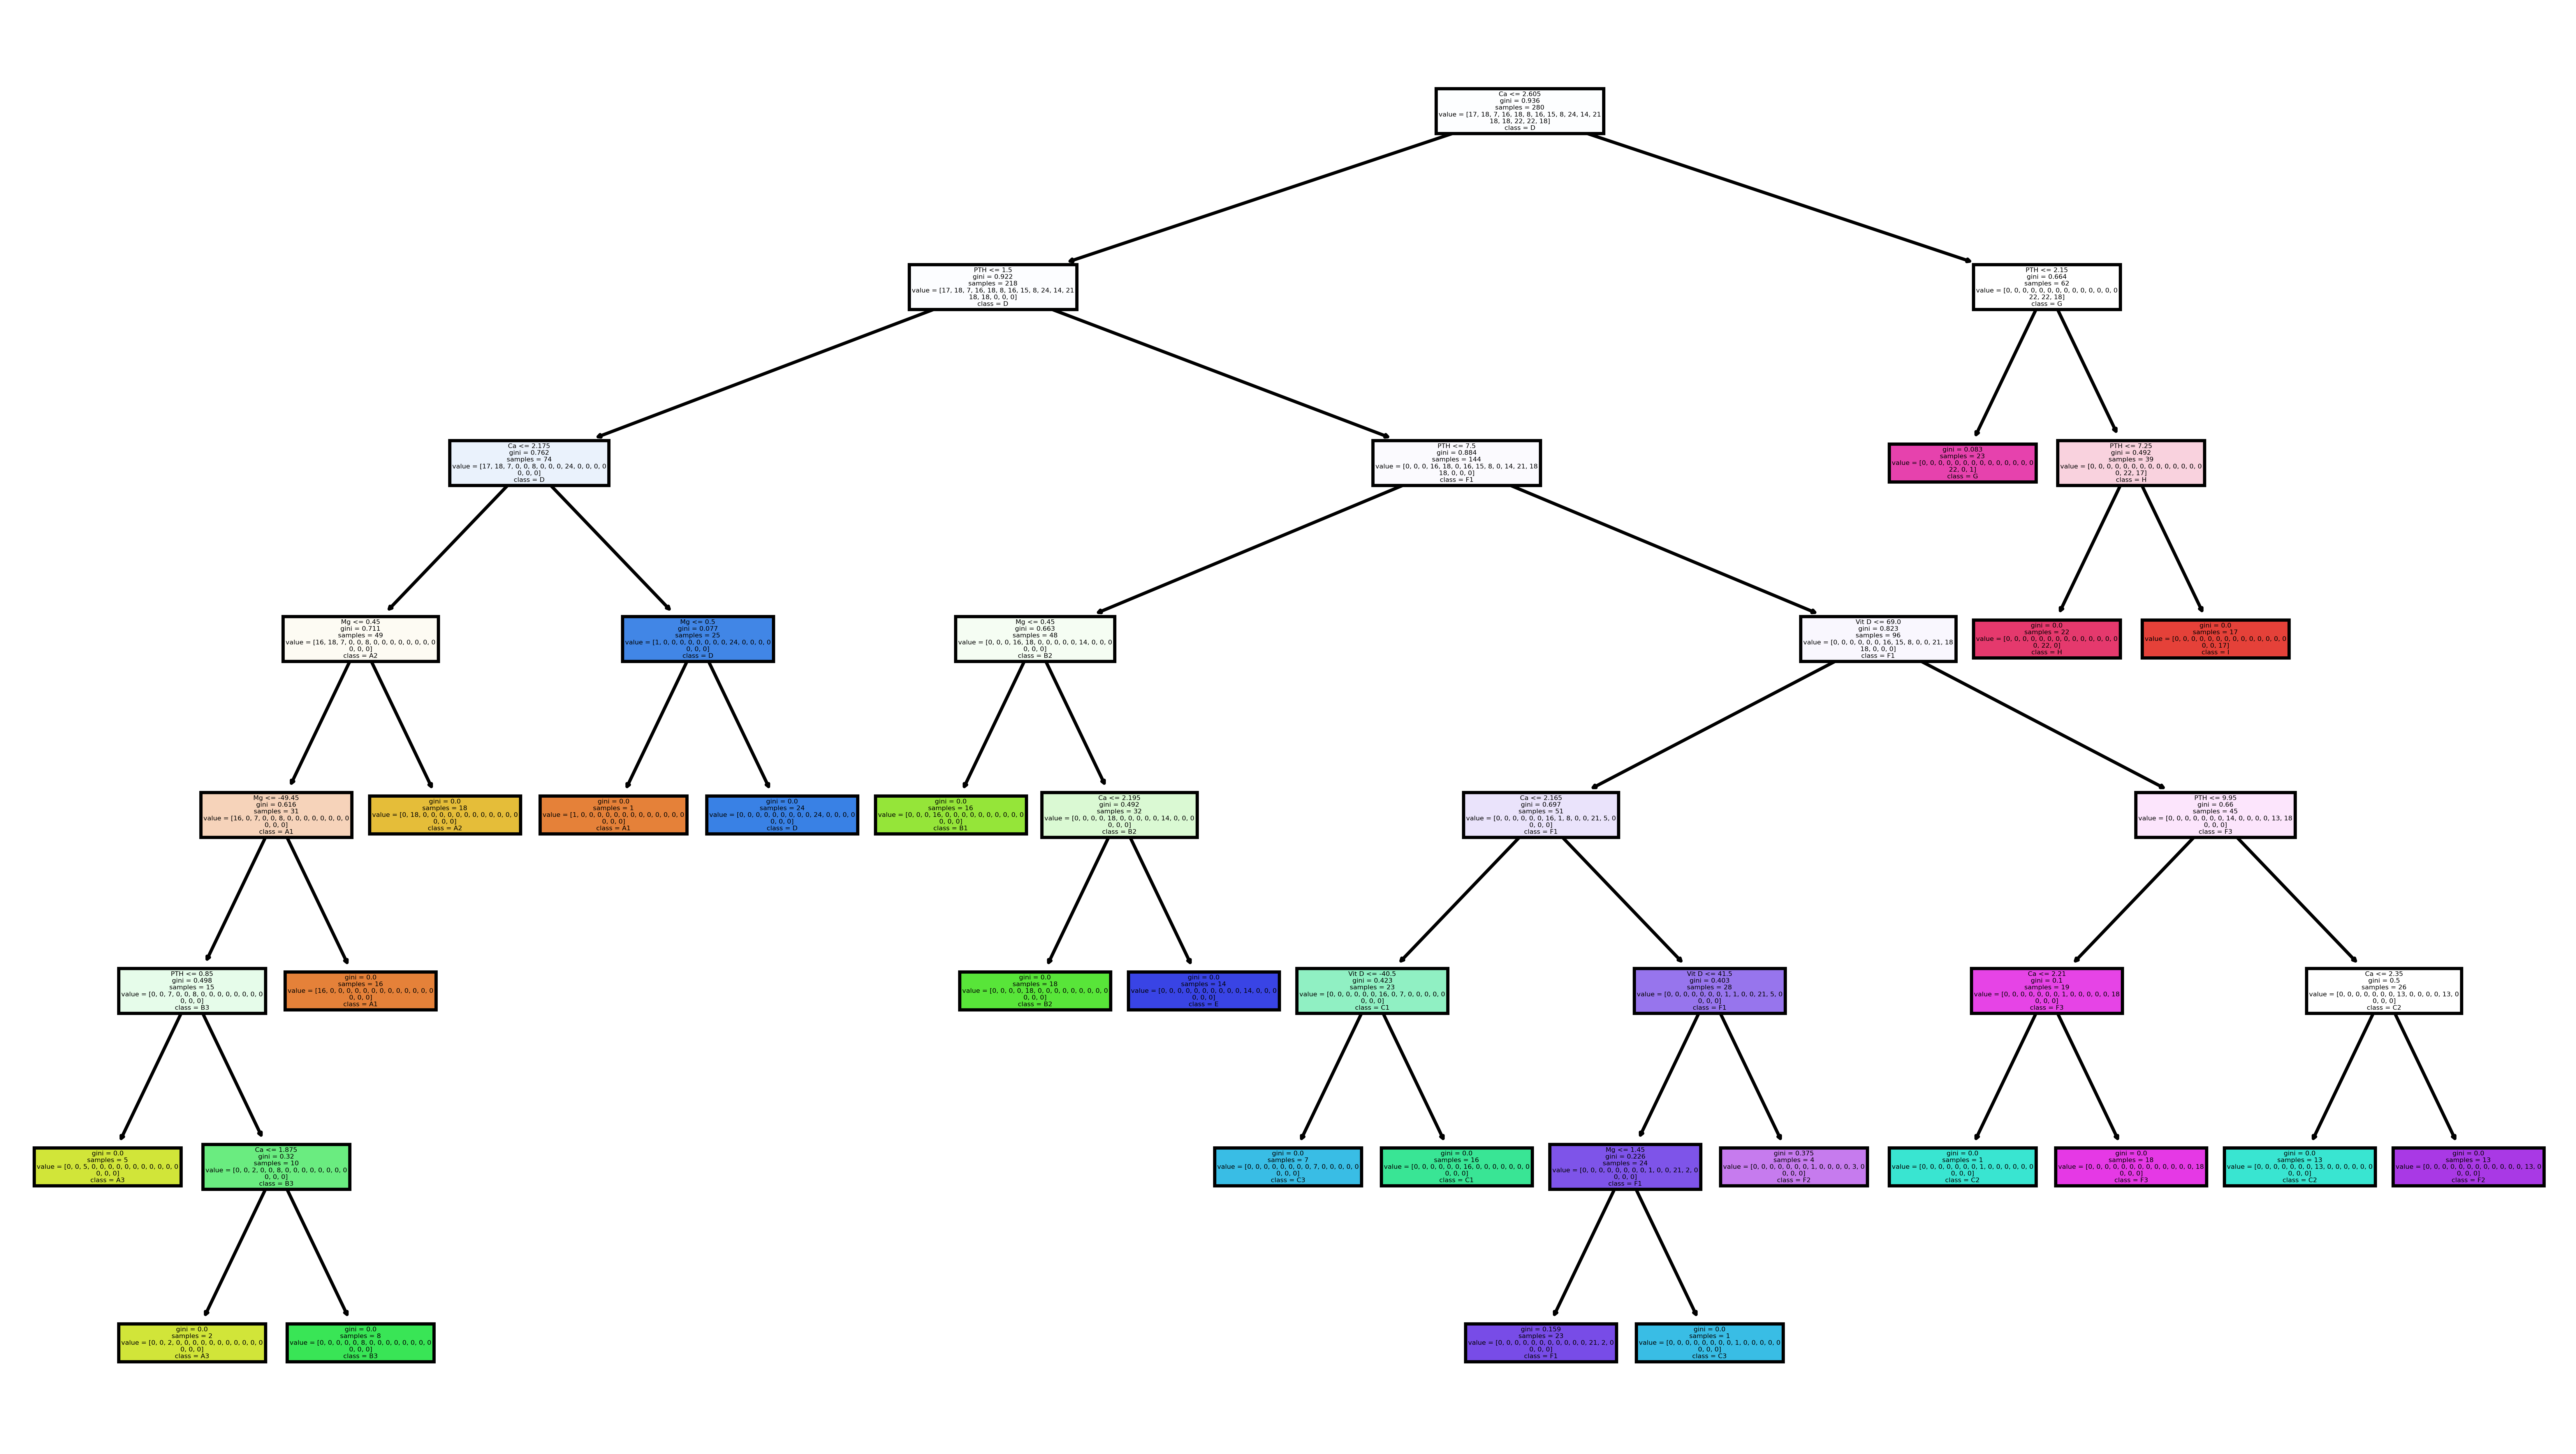

In [ ]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (14,8), dpi=800)
tree.plot_tree(best_tree,
               feature_names = features,
               class_names=class_labels,
               filled = True);
fig.savefig('/content/drive/MyDrive/MSc Project/pruned_tree.png')

In [31]:
print(classification_report(Y_validation, best_tree.predict(X_validation)))

              precision    recall  f1-score   support

          A1       0.67      1.00      0.80         2
          A2       1.00      1.00      1.00         2
          A3       0.00      0.00      0.00         1
          B1       1.00      1.00      1.00         5
          B2       1.00      1.00      1.00         3
          B3       0.75      0.75      0.75         4
          C1       1.00      1.00      1.00         9
          C2       1.00      1.00      1.00         5
          C3       1.00      1.00      1.00         1
           D       1.00      1.00      1.00         2
           E       1.00      1.00      1.00         9
          F1       0.75      1.00      0.86         3
          F2       1.00      0.83      0.91         6
          F3       1.00      1.00      1.00         6
           G       0.80      1.00      0.89         4
           H       1.00      1.00      1.00         3
           I       1.00      0.80      0.89         5

    accuracy              

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
print(accuracy_score(Y_validation, best_tree.predict(X_validation)))

0.9428571428571428


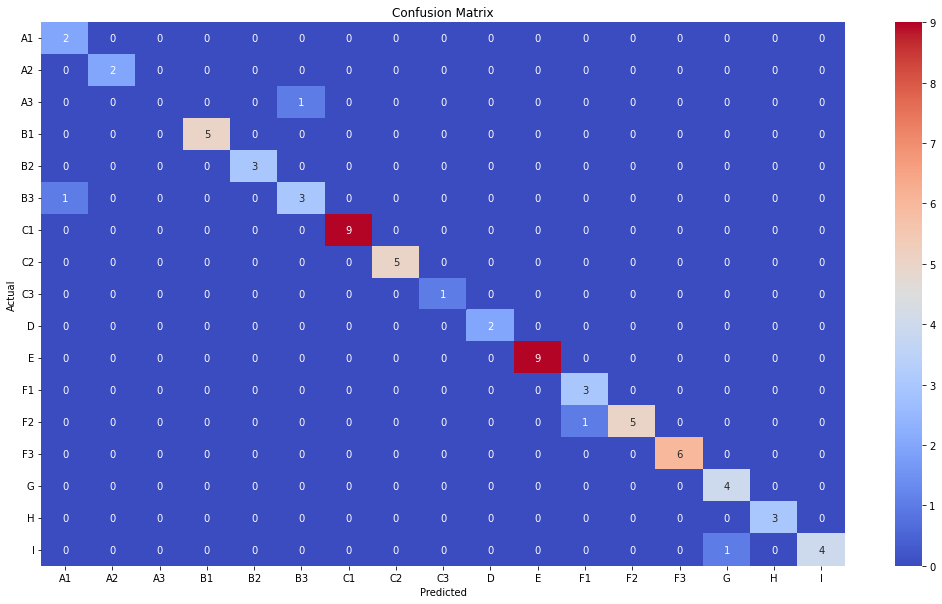

In [33]:
cf_matrix = confusion_matrix(Y_validation, best_tree.predict(X_validation))
plt.figure(figsize = (18,10))
axes = sn.heatmap(cf_matrix, cmap='coolwarm', annot=True, fmt="g")
class_labels = ['A1','A2','A3','B1','B2','B3','C1','C2','C3','D','E','F1','F2','F3','G','H','I']
tick_marks = np.arange(len(class_labels)) + 0.5

axes.set_xticks(tick_marks)
axes.set_xticklabels(class_labels,rotation=0)

axes.set_yticks(tick_marks)
axes.set_yticklabels(class_labels,rotation=0)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

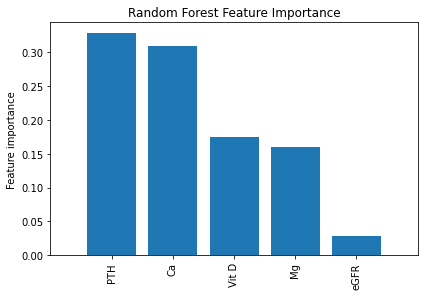

In [ ]:
importances = forest_model.feature_importances_

indices = np.argsort(importances)[::-1]

plt.ylabel('Feature importance')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        align='center')

feat_labels = dataset.columns[0:5]
plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)

plt.xlim([-1, X_train.shape[1]])

plt.tight_layout()
plt.title("Random Forest Feature Importance")
#plt.savefig('feature-importance.pdf', dpi=300)
plt.show()

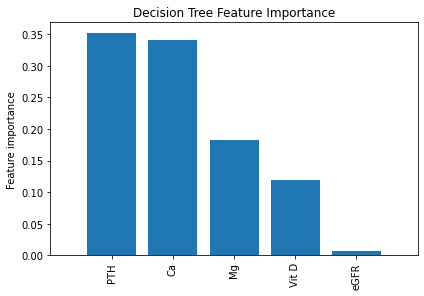

In [ ]:
importances = model.feature_importances_

indices = np.argsort(importances)[::-1]

plt.ylabel('Feature importance')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        align='center')

feat_labels = dataset.columns[0:5]
plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)

plt.xlim([-1, X_train.shape[1]])

plt.tight_layout()
plt.title("Decision Tree Feature Importance")
#plt.savefig('feature-importance.pdf', dpi=300)
plt.show()

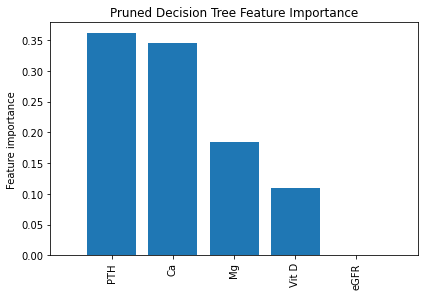

In [ ]:
importances = best_tree.feature_importances_

indices = np.argsort(importances)[::-1]

plt.ylabel('Feature importance')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        align='center')

feat_labels = dataset.columns[0:5]
plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)

plt.xlim([-1, X_train.shape[1]])

plt.tight_layout()
plt.title("Pruned Decision Tree Feature Importance")
#plt.savefig('feature-importance.pdf', dpi=300)
plt.show()